In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import numpy as np

# Homework 4 - Feature Descriptors

In [2]:
# helper functions

image_link_1 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm4.jpg?raw=true"
image_link_2 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm1.jpg?raw=true"


def download_image(image_link: str, image_name: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = image_name
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename

## Exercise 1

## Overview
Implement the function `exercise_1` that detects and matches SIFT features between two images.
This will allow to create a following algorithm:
1. Find keypoints and descriptors for both images
   (while you already know what keypoints are, the descriptors are some features that will allow you to match keypoints between images, feel free to read up on SIFT to get more information)
2. Use the cv.FlannBasedMatcher to find the best matches between descriptors of both images
3. Return the keypoints and the matches
4. Draw the matches on the images and display them

In [3]:
def exercise_1(img1: np.ndarray, img2: np.ndarray) -> tuple:
    """
    Detect and match SIFT features between two images.

    1. Find keypoints and descriptors for both images
    2. Use cv.FlannBasedMatcher to find the best matches
    3. Apply the ratio test (as described by David Lowe, feel free to google it, with threshold 0.6)
    4. Return the keypoints and the matches that pass the ratio test

    :param img1: First input image
    :param img2: Second input image
    :returns: Tuple containing (keypoints1, keypoints2, matches)
        Hint: look at the arguments of cv2.drawMatches to figure out how to return the matches
    """
    # <your_code_here>
    sift = cv2.SIFT_create()
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    kp1, dsc1 = sift.detectAndCompute(img1,None)
    kp2, dsc2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 
 
    # FLANN based matcher with implementation of k nearest neighbour.
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(dsc1,dsc2,k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            
    #kp1, kp2, matches = None, None, None
    # </your_code_here>

    return kp1, kp2, good_matches


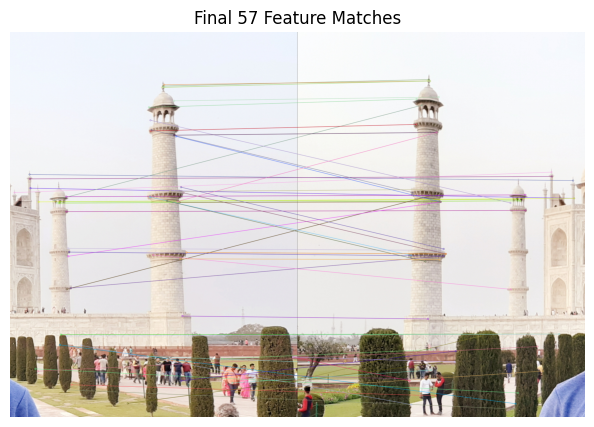

In [4]:
img1 = cv2.imread(download_image(image_link_1, "image1.jpg"))
img2 = cv2.imread(download_image(image_link_2, "image2.jpg"))
# reshape img 1 to im 2
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
# Detect and match features
kp1, kp2, final_matches = exercise_1(img1, img2)
img_matches = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    final_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


# Plot the feature matches
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Final {len(final_matches)} Feature Matches")
plt.axis("off")
plt.show()

## Exercise 2

[27.17075317 23.58678659]
[100.55981237 190.68222172]
[-3.22568532 -6.65869295]
[ 8.29735949 17.87341133]
[ 47.73004454 102.26007706]
[ 63.98232167 136.8671623 ]
[36.36309691 64.32893314]
[ 99.95506741 183.25514397]
[ 8.5485743  14.70910765]
[33.55513107 64.98062405]
[ 68.4530881  135.26217989]
[ 97.80895339 194.15340979]
[ 98.00012093 194.42342794]
[39.86482409 78.83546498]
[ 53.59011466 111.98130873]
[ 63.98232167 136.8671623 ]
[42.16308914 75.59767613]
[ 52.69718412 104.4276108 ]
[ 61.59610903 128.69216476]
[22.83214233 51.44854968]
[ 51.88283554 109.1513986 ]
[101.90117377 208.16255863]
[18.91763662 73.39867388]
[ 98.5482729  198.98594386]
[22.83214233 51.44854968]
[ 62.47095419 124.76972826]
[ 65.92661668 131.22466763]
[18.02144012 55.46374952]
[20.73260492 48.4268962 ]
best inliers are [[  8.5485743   14.70910765]
 [ 33.55513107  64.98062405]
 [ 68.4530881  135.26217989]
 [ 97.80895339 194.15340979]
 [ 98.00012093 194.42342794]]


/tmp/ipykernel_14376/36661563.py:35: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  d = abs(np.cross(p2 - p1, p - p1)/np.linalg.norm(p2 - p1))


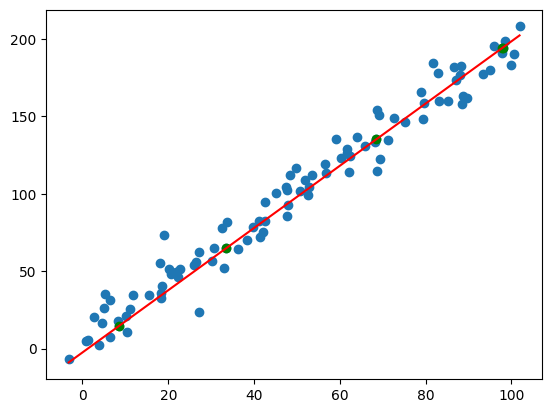

In [47]:
def exercise_2(
    points: np.ndarray,
    num_iter: int,
    threshold: float,
) -> tuple[tuple[float, float], np.ndarray]:
    """
    Implement RANSAC algorithm to fit a line to 2D points.
    1. Feel free to implement it the way you like it, just do not use cv2.RANSAC :)
    2. Setting the threshold will depend on your implementation, feel free to experiment with it
    
    :param points: Input points as Nx2 numpy array
    :param num_iter: Number of RANSAC iterations
    :param threshold: Distance threshold for inlier classification
    :returns: Tuple containing (best_model, best_inliers), where 
        - best_model is a tuple (a, b) defining the best-fit line y = ax + b
        - best_inliers is a Mx2 numpy array containing the inliers that best model has explained (M << N)
    """
    # <your_code_here>
    import random

    best_model, best_inliers = [0, 0], np.array([])

    
    for i in range(num_iter):
        current_inliers = np.empty((0,2))
        r1 = random.randint(0, len(points)-1)
        r2 = r1
        while(r2==r1):
            r2 = random.randint(0, len(points)-1)
        p1 = points[r1]
        p2 = points[r2]

        
        for p in points:
            d = abs(np.cross(p2 - p1, p - p1)/np.linalg.norm(p2 - p1))
            #print(d)

            if(d < threshold):
                print(p)
                #newrow = [1, 2, 3]
                current_inliers = np.vstack([current_inliers, p])
                #current_inliers = np.append(current_inliers, np.array([p[0] + 2137, p[1]]))
        
        #print(current_inliers)


        if(len(current_inliers) > len(best_inliers)):
            best_inliers = current_inliers
            a = (p2[1] - p1[1]) / (p2[0] - p1[0])
            b = p1[1] - a*p1[0]
            best_model = [a, b]



    print("best inliers are", best_inliers)

    #best_inliers = points
    #best_model = 2, 1
    # </your_code_here>


    return best_model, best_inliers

# the "secret"line that we want to fit (y = ax + b)
line = np.array([2, 1])
# create a dataset of 100 points that are sampled from the line y = ax + b
# add some noise to the points
points = np.array(
    [
        np.array([x, line[0] * x + line[1]]) + np.random.randn(2) * 5.0
        for x in range(100)
    ]
)
best_model, inliers = exercise_2(points, num_iter=10, threshold=0.1)

# a is the slope, b is the intercept (y = ax + b)
a, b = best_model
# inliers is a numpy array of the inliers (Nx2)
x = np.array([points[:, 0].min(), points[:, 0].max()])
y = a * x + b
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(inliers[:, 0], inliers[:, 1], color="green")
plt.plot(x, y, color="red")
plt.show()